# Blending Under Uncertainty
Prepared by Maks Kubicki (mkubicki@nd.edu) and Minho Lee (mlee56@nd.edu).

## Learning Objectives
*   Practice how to organize Pyomo model by considering uncertainties representing the 'real world' constraints.
*   Learn the Monte Carlo simulation to see the distribution of results in various random situations under uncertainties.



## Imports

In [20]:
# Imports
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.easy_install()
else:
    sys.path.insert(0, '../')
    import helper
helper.set_plotting_style()
import pyomo.environ as pyo
from scipy.stats import norm
import matplotlib.pyplot as plt
import numpy as np

--2024-11-01 00:23:19--  https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6493 (6.3K) [text/plain]
Saving to: ‘helper.py.1’

helper.py.1         100%[===================>]   6.34K  --.-KB/s    in 0s      

2024-11-01 00:23:19 (59.5 MB/s) - ‘helper.py.1’ saved [6493/6493]

idaes was found! No need to install.


## Original Linear Blending Problem
Reference: https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/02.03-Linear-Blending-Problem.html

A brewery receives an order for 100 gallons of 4% ABV (alchohol by volume) beer. The brewery has on hand beer A that is 4.5% ABV that cost USD 0.32 per gallon to make, and beer B that is 3.7% ABV and cost USD 0.25 per gallon. Water could also be used as a blending agent at a cost of USD 0.05 per gallon. Find the minimum cost blend that meets the customer requirements.

### How this project extends the original
*   +/-10% of uncertainty for the product demands with equal probabilities
*   +/-20% of uncertainty for the raw materials' costs
*   Setting minimum required water usage for blending = at least 10 gallons

Before we start to consider uncertainties, let's solve the problem including only the minimum water constraint.

### Objective Function
The objective is to minimize the expected cost of production. The cost is influenced by uncertainty in the cost of ingredients and is expressed as follows:

$$
\text{Minimize } Cost = \left( C_{A} x_A + C_{B} x_B + C_{W} x_W \right)
$$

Where:
- ${Cost}$ is the cost of blending.
- $C_{A}, C_{B}, C_{W}$ are the costs of Beer A, Beer B, and Water.
- $x_A, x_B, x_W$ are the decision variables representing the volumes of Beer A, Beer B, and Water respectively.

### Constraints
1. Volume Constraint:
   The total volume of Beer A, Beer B, and Water must be at least equal to the mean demand:
   $$
   x_A + x_B + x_W =
   $$
   Where $D$ is the mean demand.

2. ABV Constraint:
   The final blend must have an alcohol content of 4% ABV. This constraint is expressed as:
   $$
   ABV_{target} = \frac{ABV_A x_A + ABV_B x_B + ABV_W x_W}{x_A + x_B + x_W}
   $$
   Where:
   - $ABV_{target}$ is the target ABV (4%).
   - $ABV_A, ABV_B, ABV_W$ are the ABV values for Beer A, Beer B, and Water respectively.

3. Minimum Water Constraint:
   There must be at least 10 gallons of Water in the blend:
   $$
   x_W \geq 10
   $$

### Input/Data

In [21]:
data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    'W': {'abv': 0.000, 'cost': 0.05},
}

# Target ABV
abv_target = 0.04

# product demand and cost
mean_demand = 100

### Implementation without uncertainty

In [26]:
def beer_blend(vol, abv, data):
    C = data.keys()
    model = pyo.ConcreteModel()
    # Variable
    model.x = pyo.Var(C, domain=pyo.NonNegativeReals)

    # Objective
    model.cost = pyo.Objective(expr = sum(model.x[c]*data[c]['cost'] for c in C))

    # Contraints
    model.vol = pyo.Constraint(expr = vol == sum(model.x[c] for c in C)) # The final demand volume constraint
    model.abv = pyo.Constraint(expr = 0 == sum(model.x[c]*(data[c]['abv'] - abv) for c in C)) # The final abv of blending
    model.min_water = pyo.Constraint(expr = model.x['W'] >= 10) # Minimum water volume

    # Solve Problem
    solver = pyo.SolverFactory('cbc')
    solver.solve(model)

    print('Optimal Blend')
    for c in data.keys():
        print('  ', c, ':', model.x[c](), 'gallons')
    print()
    print('Volume = ', model.vol(), 'gallons')
    print('Cost = $', model.cost())

### Result without uncertainty

In [27]:
beer_blend(mean_demand, abv_target, data)

Optimal Blend
   A : 83.75 gallons
   B : 6.25 gallons
   W : 10.0 gallons

Volume =  100.0 gallons
Cost = $ 28.8625


## Monte Carlo Simulation
The Monte Carlo simulation is used to evaluate the cost under different scenarios of cost and demand uncertainty. By generating random values for the costs and demands based on given distributions, we can calculate the expected value and standard deviation of the total cost.

- Expected Cost: The average cost across all simulated scenarios.
- Standard Deviation of Cost: A measure of the variability in cost due to uncertainties in demand and ingredient prices.

The results are visualized to understand the distribution of the cost and the optimal blend composition.

### Data of model considering uncertainties

In [28]:
# parameters for ABV
abv_A = 0.045
abv_B = 0.037
abv_W = 0.000

# product demand and cost
mean_demand = 100
mean_cost_A = 0.32
mean_cost_B = 0.25
mean_cost_W = 0.05

# Demand and Cost uncertainty as continuous distributions
std_dev_demand = 10
std_dev_cost_A = 0.064
std_dev_cost_B = 0.05
std_dev_cost_W = 0.01

## Mathematical Formulation of the Monte Calro Blending Problem

The blending problem aims to determine the optimal volumes of Beer A, Beer B, and Water required to produce a target volume of beer with a specific Alcohol By Volume (ABV) while minimizing the cost.

### Objective Function
The objective is to minimize the expected cost of production. The cost is influenced by uncertainty in the cost of ingredients and is expressed as follows:

$$
\text{Minimize } E[\text{Cost}] = \frac{1}{N} \sum_{i=1}^N \left( C_{A,i} x_A + C_{B,i} x_B + C_{W,i} x_W \right)
$$

Where:
- $E[\text{Cost}]$ is the expected cost.
- $N$ is the number of scenarios.
- $C_{A,i}, C_{B,i}, C_{W,i}$ are the costs of Beer A, Beer B, and Water in scenario $i$.
- $x_A, x_B, x_W$ are the decision variables representing the volumes of Beer A, Beer B, and Water respectively.

### Constraints
1. Volume Constraint:
   The total volume of Beer A, Beer B, and Water must be at least equal to the mean demand:
   $$
   x_A + x_B + x_W \geq D
   $$
   Where $D$ is the mean demand.

2. ABV Constraint:
   The final blend must have an alcohol content of 4% ABV. This constraint is expressed as:
   $$
   ABV_{target} = \frac{ABV_A x_A + ABV_B x_B + ABV_W x_W}{x_A + x_B + x_W}
   $$
   Where:
   - $ABV_{target}$ is the target ABV (4%).
   - $ABV_A, ABV_B, ABV_W$ are the ABV values for Beer A, Beer B, and Water respectively.

3. Minimum Water Constraint:
   There must be at least 10 gallons of Water in the blend:
   $$
   x_W \geq 10
   $$

### Create the Pyomo Monte Carlo model

In [29]:
# creating a Pyomo model
model = pyo.ConcreteModel()

# generating continuous random demands and costs for Monte Carlo simulation
num_scenarios = 10000000
demands = norm.rvs(loc=mean_demand, scale=std_dev_demand, size=num_scenarios)
costs_A = norm.rvs(loc=mean_cost_A, scale=std_dev_cost_A, size=num_scenarios)
costs_B = norm.rvs(loc=mean_cost_B, scale=std_dev_cost_B, size=num_scenarios)
costs_W = norm.rvs(loc=mean_cost_W, scale=std_dev_cost_W, size=num_scenarios)

# decision variables (note: decisions must be the same across scenarios)
model.x_A = pyo.Var(domain=pyo.NonNegativeReals)
model.x_B = pyo.Var(domain=pyo.NonNegativeReals)
model.x_W = pyo.Var(domain=pyo.NonNegativeReals)

# objective function: minimize the expected cost
def Objective_rule(model):
    return sum((costs_A[i] * model.x_A + costs_B[i] * model.x_B + costs_W[i] * model.x_W) / num_scenarios for i in range(num_scenarios))
model.Obj = pyo.Objective(rule=Objective_rule, sense=pyo.minimize)

# constraints
# volume constraint (decision made before knowing exact demand)
def Volume_rule(model):
    return model.x_A + model.x_B + model.x_W >= mean_demand
model.Volume = pyo.Constraint(rule=Volume_rule)

# ABV constraint
def Abv_rule(model):
    return abv_target == (abv_A * model.x_A + abv_B * model.x_B + abv_W * model.x_W) / (model.x_A + model.x_B + model.x_W)
model.Abv = pyo.Constraint(rule=Abv_rule)

# minimum water constraint
def Min_Water_rule(model):
    return model.x_W >= 10
model.Min_Water = pyo.Constraint(rule=Min_Water_rule)

In [30]:
# solving the problem
solver = pyo.SolverFactory("ipopt")
solver.solve(model)

# extracting results
x_A_value = pyo.value(model.x_A)
x_B_value = pyo.value(model.x_B)
x_W_value = pyo.value(model.x_W)

# presenting optimal values for volume of ingredients
print(f"Optimal Volume of Beer A: {x_A_value:.2f} gallons")
print(f"Optimal Volume of Beer B: {x_B_value:.2f} gallons")
print(f"Optimal Volume of Water: {x_W_value:.2f} gallons")

# running Monte Carlo simulation to evaluate the cost under different scenarios
total_costs = []
for i in range(num_scenarios):
    cost = costs_A[i] * x_A_value + costs_B[i] * x_B_value + costs_W[i] * x_W_value
    total_costs.append(cost)

# calculating and printing expected cost and standard deviation
expected_cost = np.mean(total_costs)
std_dev_cost = np.std(total_costs)
print(f"Expected Total Cost: {expected_cost:.2f} USD")
print(f"Standard Deviation of Total Cost: {std_dev_cost:.2f} USD")

Optimal Volume of Beer A: 83.75 gallons
Optimal Volume of Beer B: 6.25 gallons
Optimal Volume of Water: 10.00 gallons
Expected Total Cost: 28.86 USD
Standard Deviation of Total Cost: 5.37 USD


### Visualize Results

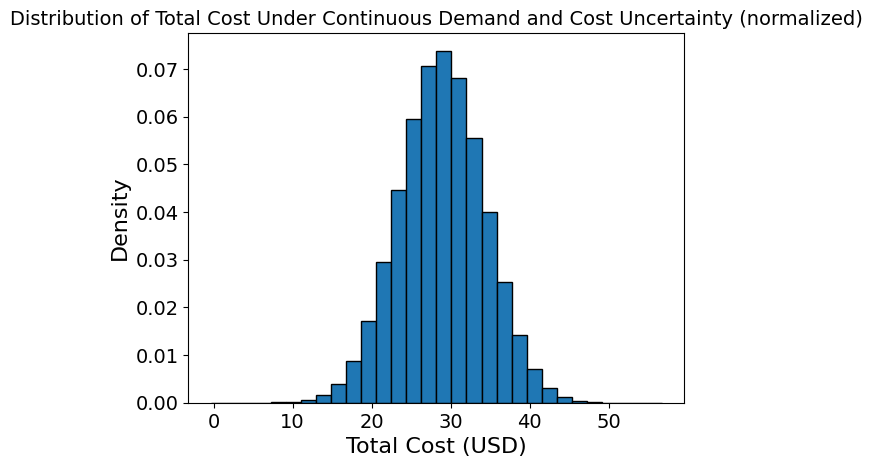

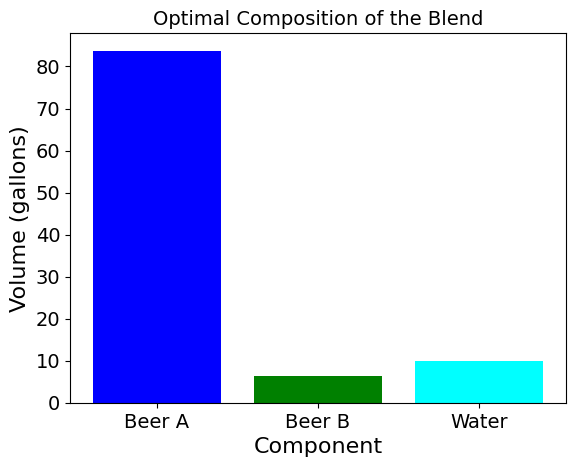

In [31]:
# visualizing the cost distribution (normalized)
plt.hist(total_costs, bins=30, density=True, edgecolor='black')
plt.xlabel('Total Cost (USD)')
plt.ylabel('Density')
plt.title('Distribution of Total Cost Under Continuous Demand and Cost Uncertainty (normalized)')
plt.show()

# visualizing the optimal composition
components = ['Beer A', 'Beer B', 'Water']
volumes = [x_A_value, x_B_value, x_W_value]

plt.bar(components, volumes, color=['blue', 'green', 'aqua'])
plt.xlabel('Component')
plt.ylabel('Volume (gallons)')
plt.title('Optimal Composition of the Blend')
plt.show()

## Comparison of results with and without uncertainty
* Without Uncertainty Results
    Optimal Blend
      A : 83.75 gallons
      B : 6.25 gallons
      W : 10.0 gallons
    Cost = $ 28.86

* With Uncertainty Results
    Optimal Blend
      Beer A: 83.75 gallons
      Beer B: 6.25 gallons
      Water: 10.00 gallons
    Expected Total Cost: 28.86 USD


Both problems showed same volumes of each component and total cost.


## Degrees of Freedom Analysis
* Decision Variables:

    Volume of Beer A, Beer B, and Water (3 Variables)

* Constraints:

    Volume constraint, ABV constraint, and Minimum water constraint (3 constraint)

* Degree of Freedom (DoF):

$$
\text{Degree of Freedom} = \text{Number of Variables} - \text{Number of Constraints}
$$

$$
3 - 3 = 0 \text{DoF}
$$

This model has zero degree of freedom. That means the problem is exhibits robustness to uncertainty.

## Reference
*   Jenchura (2017). Linear Blending Problem. ND Pyomo Cookbook. https://jckantor.github.io/ND-Pyomo-Cookbook/notebooks/02.03-Linear-Blending-Problem.html

